In [1]:
# Wczytanie pakietów

using StatsBase       
using Random          
using DataStructures  
using Parameters      
using DataFrames  
using Plots    


In [2]:
# Wczytanie rozkładów czasów obsługi poszczególnych konsultantów oraz odstępów pomiędzy przybyciem kolejnego klienta

czasy_najlepszego = [
  3 25;
  4 30;
  5 30;
  6 25;      
]

czasy_lepszego = [
  4 35;
  5 25;
  6 20;
  7 20
]
czasy_średniego = [
  6 25;
  7 25;
  8 30;
  9 20
]

czasy_gorszego = [
  8 15;
  9 25;
  10 40;
  11 20
]

przybycie_klienta_rano = [
  1 30;
  2 25;
  3 20;
  4 15
]

przybycie_klienta_popołudnie = [
  1 20;
  2 15;
  3 10;
  4 5
]


4×2 Matrix{Int64}:
 1  20
 2  15
 3  10
 4   5

In [3]:
# Stworzenie struktury opisującej parametryzację modelu

@with_kw mutable struct CallCenter
    tick::Int  = 0 
    czasy_najlepszego::Matrix{Int}
    czasy_lepszego::Matrix{Int}
    czasy_średniego::Matrix{Int}
    czasy_gorszego::Matrix{Int} 
    przybycie_klienta_rano::Matrix{Int}    
    przybycie_klienta_popołudnie::Matrix{Int}                      
    q::PriorityQueue{Function, Tuple{Int,Int}}=PriorityQueue{Function, Tuple{Int,Int}}()
    log::DataFrame = DataFrame()
    poczekalnia::Int = 0 
    zajęty_najlepszy::Bool = false
    zajęty_lepszy::Bool = false
    zajęty_średni::Bool = false
    zajęty_gorszy::Bool = false
    najlepszy::Bool 
    lepszy::Bool
    średni::Bool
    gorszy::Bool 
    liczba_obsłużonych_przez_najlepszego::Int = 0
    liczba_obsłużonych_przez_lepszego::Int = 0
    liczba_obsłużonych_przez_średniego::Int = 0
    liczba_obsłużonych_przez_gorszego::Int = 0
    minuta_przybycia::Vector{Int} = Int[]
    minuta_obsługi::Vector{Int} = Int[]
    czas_obsługi_przez_najlepszego::Vector{Int} = Int[]
    czas_obsługi_przez_lepszego::Vector{Int} = Int[]
    czas_obsługi_przez_średniego::Vector{Int} = Int[]
    czas_obsługi_przez_gorszego::Vector{Int} = Int[]
    średni_czas_oczekiwania::Float64 = 0.0
end


CallCenter

In [4]:
# Zdefiniowanie funkcji opisujących poszczególne zdarzenia

function nowy_klient!(sim::CallCenter, time::Int)
    if time < 60*4 # po 4 godzinach zmienia się rozkład odstępów pomiędzy przybyciem kolejnego klienta
        odstęp = sample(sim.przybycie_klienta_rano[:,1], Weights(sim.przybycie_klienta_rano[:,2]))
    else
        odstęp = sample(sim.przybycie_klienta_popołudnie[:,1], Weights(sim.przybycie_klienta_popołudnie[:,2]))
    end
    sim.poczekalnia += 1 # każdy klient po zadzwonieniu trafia do poczekalni
    enqueue!(sim.q, nowy_klient!, (time+odstęp, 0))
    if sim.najlepszy # telefon odbierają konsultanci w kolejności od najlepszego do najgorszego (o ile dany konsultant pracuje)
        enqueue!(sim.q, najlepszy_sprawdza!, (time, 10)) 
    elseif sim.lepszy 
        enqueue!(sim.q, lepszy_sprawdza!, (time, 10)) 
    elseif sim.średni 
        enqueue!(sim.q, średni_sprawdza!, (time, 10))
    elseif sim.gorszy 
        enqueue!(sim.q, gorszy_sprawdza!, (time, 10))
    end
    push!(sim.minuta_przybycia, time)
end

function najlepszy_sprawdza!(sim::CallCenter, time::Int)
    if sim.poczekalnia > 0 && !sim.zajęty_najlepszy 
        enqueue!(sim.q, najlepszy_obsługuje!, (time,20)  ) # jeśli klient czeka w poczekalni i dany konsultant nie jest zajęty to zaczyna go obsługiwać 
    elseif sim.poczekalnia > 0                             # jeśli klient czeka w poczekalni i dany konsultant jest zajęty to sprawdzana jest dostępność kolejnego konsultanta
        if sim.lepszy
            enqueue!(sim.q, lepszy_sprawdza!, (time, 10))
        elseif sim.średni
            enqueue!(sim.q, średni_sprawdza!, (time, 10)) 
        elseif sim.gorszy
            enqueue!(sim.q, gorszy_sprawdza!, (time, 10)) 
        end        
    end 
end

function lepszy_sprawdza!(sim::CallCenter, time::Int)
    if sim.poczekalnia > 0 && !sim.zajęty_lepszy
        enqueue!(sim.q, lepszy_obsługuje!, (time,20)  )
    elseif sim.poczekalnia > 0 
        if sim.średni
        enqueue!(sim.q, średni_sprawdza!, (time, 10))
        elseif sim.gorszy
            enqueue!(sim.q, gorszy_sprawdza!, (time, 10)) 
        end        
    end 
end

function średni_sprawdza!(sim::CallCenter, time::Int)
    if sim.poczekalnia > 0 && !sim.zajęty_średni
        enqueue!(sim.q, średni_obsługuje!, (time,20)  )
    elseif sim.poczekalnia > 0 
        if sim.gorszy
            enqueue!(sim.q, gorszy_sprawdza!, (time, 10)) 
        end        
    end 
end

function gorszy_sprawdza!(sim::CallCenter, time::Int)
    if sim.poczekalnia > 0 && !sim.zajęty_gorszy
        enqueue!(sim.q, gorszy_obsługuje!, (time,20)  )       
    end 
end

function najlepszy_obsługuje!(sim::CallCenter, time::Int)
    sim.zajęty_najlepszy =true
    sim.poczekalnia -= 1
    czas_obsługi_najlepszy = sample(sim.czasy_najlepszego[:,1], Weights(sim.czasy_najlepszego[:,2]))
    enqueue!(sim.q, najlepszy_kończy!,(time + czas_obsługi_najlepszy, 30)) 
    push!(sim.minuta_obsługi, time) 
    push!(sim.czas_obsługi_przez_najlepszego, czas_obsługi_najlepszy) 
end

function najlepszy_kończy!(sim::CallCenter, time::Int)
    sim.zajęty_najlepszy = false
    sim.liczba_obsłużonych_przez_najlepszego += 1
    enqueue!(sim.q, najlepszy_sprawdza!,(time, 5))  
end

function lepszy_obsługuje!(sim::CallCenter, time::Int)
    sim.zajęty_lepszy =true
    sim.poczekalnia -= 1
    czas_obsługi_lepszy = sample(sim.czasy_lepszego[:,1], Weights(sim.czasy_lepszego[:,2]))
    enqueue!(sim.q, lepszy_kończy!,(time + czas_obsługi_lepszy, 40)) 
    push!(sim.minuta_obsługi, time) 
    push!(sim.czas_obsługi_przez_lepszego, czas_obsługi_lepszy) 
end

function lepszy_kończy!(sim::CallCenter, time::Int)
    sim.zajęty_lepszy = false
    sim.liczba_obsłużonych_przez_lepszego += 1
    enqueue!(sim.q, lepszy_sprawdza!,(time, 5))  
end

function średni_obsługuje!(sim::CallCenter, time::Int)
    sim.zajęty_średni =true
    sim.poczekalnia -= 1
    czas_obsługi_średniego = sample(sim.czasy_średniego[:,1], Weights(sim.czasy_średniego[:,2]))
    enqueue!(sim.q, średni_kończy!,(time + czas_obsługi_średniego, 50)) 
    push!(sim.minuta_obsługi, time) 
    push!(sim.czas_obsługi_przez_średniego, czas_obsługi_średniego) 
end

function średni_kończy!(sim::CallCenter, time::Int)
    sim.zajęty_średni = false
    sim.liczba_obsłużonych_przez_średniego += 1
    enqueue!(sim.q, średni_sprawdza!,(time, 5))  
end

function gorszy_obsługuje!(sim::CallCenter, time::Int)
    sim.zajęty_gorszy = true
    sim.poczekalnia -= 1
    czas_obsługi_gorszy = sample(sim.czasy_gorszego[:,1], Weights(sim.czasy_gorszego[:,2]))
    enqueue!(sim.q, gorszy_kończy!,(time + czas_obsługi_gorszy, 60))
    push!(sim.minuta_obsługi, time)   
    push!(sim.czas_obsługi_przez_gorszego, czas_obsługi_gorszy) 
end

function gorszy_kończy!(sim::CallCenter, time::Int)
    sim.zajęty_gorszy = false
    sim.liczba_obsłużonych_przez_gorszego += 1
    enqueue!(sim.q, gorszy_sprawdza!,(time, 5))  
end


gorszy_kończy! (generic function with 1 method)

In [5]:
# Zdefiniowanie funkcji uruchamiającej model

function step!(sim;log=true)
    if sim.tick == 0 # w zerowym kroku symulacji pierwszym zdarzeniem jest przybycie nowego klienta
        nowy_klient!(sim, 0)
    end
    
    sim.tick += 1
    fun, time_p = dequeue_pair!(sim.q)
    time = time_p[1]
    fun(sim, time)   
    log && append!(sim.log, DataFrame(tick=sim.tick, time=time, fun=string(fun), poczekalnia = sim.poczekalnia, l_obs_p_naj = sim.liczba_obsłużonych_przez_najlepszego,l_obs_p_lep = sim.liczba_obsłużonych_przez_lepszego, l_obs_p_śr = sim.liczba_obsłużonych_przez_średniego, l_obs_p_gor = sim.liczba_obsłużonych_przez_gorszego))
    return time
end

step! (generic function with 1 method)

In [6]:
# Przykładowa symulacja dla 1000 kroków

Random.seed!(1)
model = CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                    przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                    najlepszy = true, lepszy = true, średni = true, gorszy = true) # wybranie, którzy konsultanci pracują
for _ in 1:1000
    step!(model)
end
model.log


Row,tick,time,fun,poczekalnia,l_obs_p_naj,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64
1,1,0,najlepszy_sprawdza!,1,0,0,0,0
2,2,0,najlepszy_obsługuje!,0,0,0,0,0
3,3,1,nowy_klient!,1,0,0,0,0
4,4,1,najlepszy_sprawdza!,1,0,0,0,0
5,5,1,lepszy_sprawdza!,1,0,0,0,0
6,6,1,lepszy_obsługuje!,0,0,0,0,0
7,7,4,nowy_klient!,1,0,0,0,0
8,8,4,najlepszy_sprawdza!,1,0,0,0,0
9,9,4,lepszy_sprawdza!,1,0,0,0,0


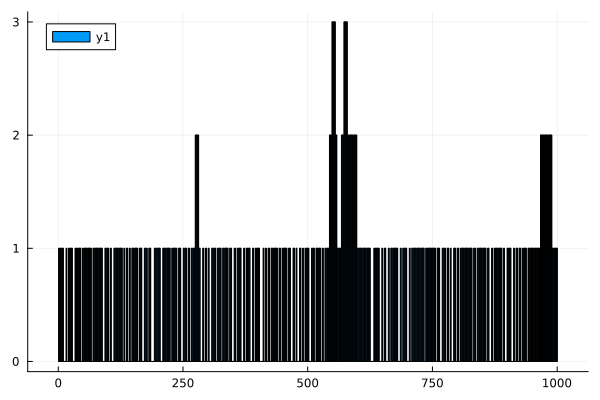

In [7]:
# Wykres liczby osób w poczekalni w przykładowej symulacji

Plots.bar(model.log.tick, model.log.poczekalnia)


In [8]:
# Zdefiniowanie funkcji symulującej 10-godzinny dzień pracy

function simulate!(sim;log=false)
    time = 0
    while time <= 60*10
        time = step!(sim;log=log)   
    end
    czasy_oczekiwania = sim.minuta_obsługi - sim.minuta_przybycia[1:length(sim.minuta_obsługi)]
    sim.średni_czas_oczekiwania = sum(czasy_oczekiwania) / (sim.liczba_obsłużonych_przez_najlepszego + sim.liczba_obsłużonych_przez_lepszego + sim.liczba_obsłużonych_przez_średniego + sim.liczba_obsłużonych_przez_gorszego)
    return (śr_czas_ocz = sim.średni_czas_oczekiwania, 
            czas_pracy_naj = sum(sim.czas_obsługi_przez_najlepszego), czas_pracy_lep = sum(sim.czas_obsługi_przez_lepszego), czas_pracy_śr = sum(sim.czas_obsługi_przez_średniego), czas_pracy_gor = sum(sim.czas_obsługi_przez_gorszego),
            l_obs_p_najlep = sim.liczba_obsłużonych_przez_najlepszego,l_obs_p_lep = sim.liczba_obsłużonych_przez_lepszego,l_obs_p_śr = sim.liczba_obsłużonych_przez_średniego, l_obs_p_gor = sim.liczba_obsłużonych_przez_gorszego)
end


simulate! (generic function with 1 method)

In [9]:
# Symulacja dla całego dnia pracy

Random.seed!(1)
model = CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                    przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                    najlepszy = true, lepszy = true, średni = true, gorszy = true)
simulate!(model)


(śr_czas_ocz = 0.30434782608695654, czas_pracy_naj = 487, czas_pracy_lep = 476, czas_pracy_śr = 461, czas_pracy_gor = 443, l_obs_p_najlep = 105, l_obs_p_lep = 89, l_obs_p_śr = 60, l_obs_p_gor = 45)

Wariant: wszyscy pracują

In [24]:
# 1000 symulacji całego dnia pracy

Random.seed!(1)

df = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                        najlepszy = true, lepszy = true, średni = true, gorszy = true))
    for n in 1:1000)
        

Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0.304348,487,476,461,443,105,89,60,45
2,0.231834,486,457,422,442,102,85,57,45
3,0.196552,471,455,435,421,106,86,56,42
4,0.361111,489,454,422,395,108,85,55,40
5,0.248276,473,475,441,371,104,89,60,37
6,0.299663,490,464,432,397,109,91,56,41
7,0.246575,484,463,462,398,106,85,61,40
8,0.134948,473,452,438,396,105,88,57,39
9,0.286232,466,428,419,331,108,80,55,33


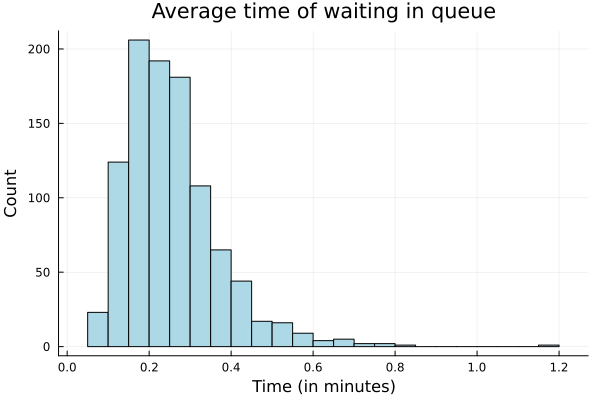

In [25]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df.śr_czas_ocz, fillcolor="lightblue", label=false, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue" )


In [26]:
# Wykorzystanie stanowiska

mean(df.śr_czas_ocz),mean(df.czas_pracy_naj)/(60*10), mean(df.czas_pracy_lep)/(60*10), mean(df.czas_pracy_śr)/(60*10), mean(df.czas_pracy_gor)/(60*10)

(0.2568621056398785, 0.7923083333333333, 0.7511316666666666, 0.7146633333333333, 0.6344566666666667)

Wariant: bez najlepszego

In [28]:
# 1000 symulacji całego dnia pracy

Random.seed!(1)

df = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                        najlepszy = false, lepszy = true, średni = true, gorszy = true))
    for n in 1:1000)
        

Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,17.3202,0,591,597,603,0,112,79,62
2,27.1765,0,599,606,604,0,115,79,61
3,25.0444,0,577,583,588,0,112,76,60
4,37.298,0,601,601,596,0,112,81,62
5,24.2087,0,596,595,598,0,113,79,62
6,21.24,0,577,575,578,0,110,81,59
7,29.7743,0,604,605,599,0,114,82,61
8,35.1833,0,596,595,596,0,111,80,60
9,22.7402,0,601,596,596,0,117,76,61


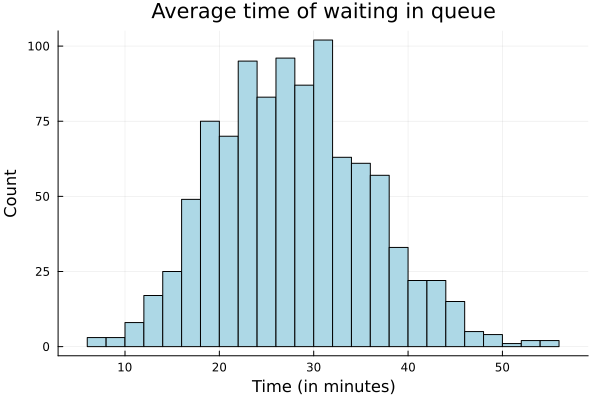

In [29]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df.śr_czas_ocz, fillcolor="lightblue", label=false, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue" )


In [30]:
# Wykorzystanie stanowiska

mean(df.śr_czas_ocz),mean(df.czas_pracy_naj)/(60*10), mean(df.czas_pracy_lep)/(60*10), mean(df.czas_pracy_śr)/(60*10), mean(df.czas_pracy_gor)/(60*10)

(27.793699992171888, 0.0, 0.9969183333333332, 0.9960083333333334, 0.9946866666666667)

Wariant: bez lepszego

In [34]:
# 1000 symulacji całego dnia pracy

Random.seed!(1)

df = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                        najlepszy = true, lepszy = false, średni = true, gorszy = true))
    for n in 1:1000)
        

Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,12.8764,590,0,594,593,127,0,79,61
2,8.66171,583,0,590,587,130,0,79,60
3,7.57308,572,0,582,567,126,0,76,58
4,6.74074,588,0,589,591,129,0,80,61
5,10.7022,585,0,590,585,135,0,78,59
6,7.22509,589,0,596,585,132,0,80,59
7,14.3481,599,0,593,605,130,0,79,61
8,8.92989,593,0,590,590,131,0,80,60
9,15.3708,593,0,591,590,128,0,79,60


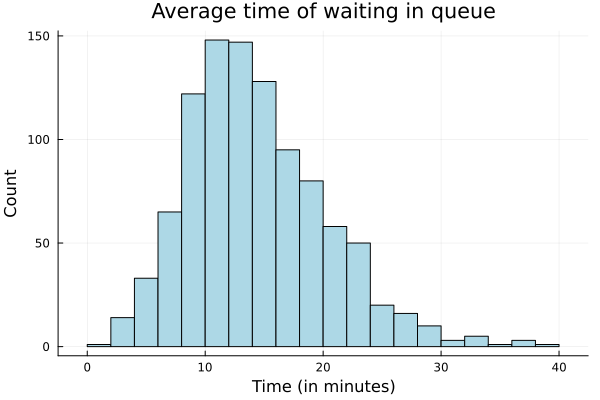

In [35]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df.śr_czas_ocz, fillcolor="lightblue", label=false, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue" )


In [36]:
# Wykorzystanie stanowiska

mean(df.śr_czas_ocz),mean(df.czas_pracy_naj)/(60*10), mean(df.czas_pracy_lep)/(60*10), mean(df.czas_pracy_śr)/(60*10), mean(df.czas_pracy_gor)/(60*10)

(14.399287441076286, 0.9823333333333333, 0.0, 0.9829066666666667, 0.9813566666666667)

Wariant: bez średniego

In [31]:
# 1000 symulacji całego dnia pracy

Random.seed!(1)

df = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                        najlepszy = true, lepszy = true, średni = false, gorszy = true))
    for n in 1:1000)
        

Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,4.22581,558,537,0,574,120,100,0,59
2,5.77737,543,524,0,524,123,98,0,53
3,1.35294,542,518,0,541,118,98,0,56
4,2.88014,566,571,0,582,126,108,0,58
5,6.67845,554,538,0,551,127,101,0,55
6,4.29655,573,556,0,573,126,106,0,58
7,1.42491,538,515,0,522,119,100,0,54
8,9.9258,568,549,0,559,125,103,0,55
9,1.64234,549,534,0,527,119,102,0,53


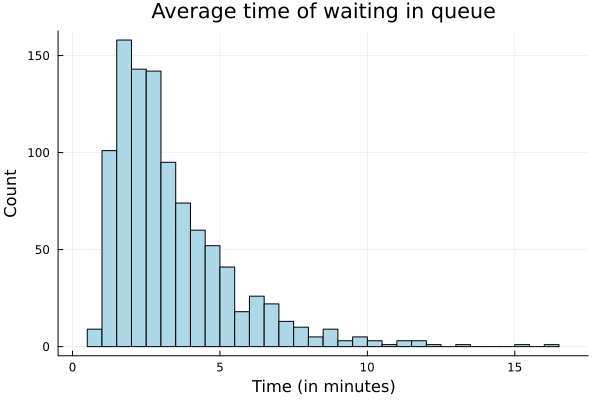

In [32]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df.śr_czas_ocz, fillcolor="lightblue", label=false, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue" )


In [33]:
# Wykorzystanie stanowiska

mean(df.śr_czas_ocz),mean(df.czas_pracy_naj)/(60*10), mean(df.czas_pracy_lep)/(60*10), mean(df.czas_pracy_śr)/(60*10), mean(df.czas_pracy_gor)/(60*10)

(3.3699237417383423, 0.93231, 0.91396, 0.0, 0.9186366666666667)

Wariant: bez gorszego

In [37]:
# 1000 symulacji całego dnia pracy

Random.seed!(1)

df = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                        najlepszy = true, lepszy = true, średni = true, gorszy = false))
    for n in 1:1000)
        

Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1.46048,546,547,537,0,117,103,71,0
2,1.1413,521,504,471,0,116,97,63,0
3,2.1512,553,537,538,0,119,103,69,0
4,0.724014,525,509,499,0,115,99,65,0
5,1.55208,536,520,518,0,119,99,70,0
6,2.07333,566,550,551,0,124,103,73,0
7,2.27703,554,547,559,0,120,103,73,0
8,1.41319,535,517,511,0,123,99,66,0
9,1.49819,516,525,481,0,115,98,64,0


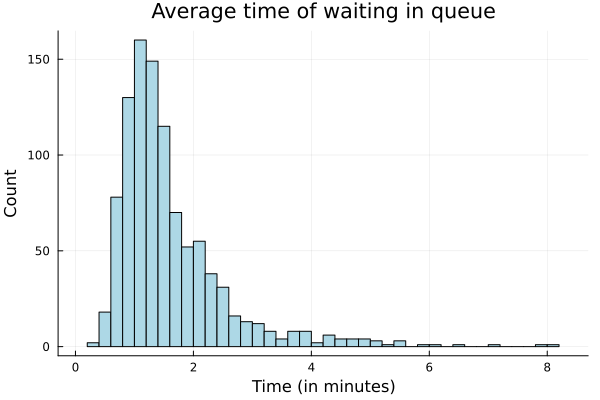

In [38]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df.śr_czas_ocz, fillcolor="lightblue", label=false, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue" )


In [39]:
# Wykorzystanie stanowiska

mean(df.śr_czas_ocz),mean(df.czas_pracy_naj)/(60*10), mean(df.czas_pracy_lep)/(60*10), mean(df.czas_pracy_śr)/(60*10), mean(df.czas_pracy_gor)/(60*10)

(1.6109387605516936, 0.8955350000000001, 0.869975, 0.8535783333333334, 0.0)

In [14]:
#Analiza wrażliwości - założenie jednakowych (porannych) rozkładów częstotliwości przybywania klientów. Rozwiązanie optymalne


Random.seed!(123)

df1 = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_najlepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_średniego, czasy_gorszego = czasy_gorszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_rano, 
                        najlepszy = true, lepszy = false, średni = true, gorszy = true))
    for n in 1:1000)

Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,7.31955,594,0,596,590,127,0,79,60
2,1.93701,557,0,562,567,123,0,73,58
3,6.68519,583,0,593,571,132,0,79,59
4,4.327,576,0,579,578,128,0,76,59
5,2.82239,572,0,575,569,125,0,76,58
6,2.85057,560,0,568,562,127,0,76,58
7,5.76316,593,0,595,590,127,0,79,60
8,6.55957,604,0,599,594,135,0,82,60
9,3.08915,567,0,564,585,123,0,75,60


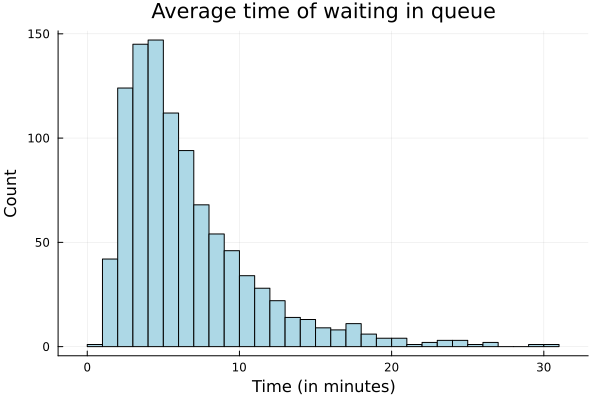

In [15]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df1.śr_czas_ocz, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue", fillcolor="lightblue", label=false)

In [16]:
#Średni czas oczekiwania
mean(df1.śr_czas_ocz)

6.592636062310333

In [17]:
# Wykorzystanie stanowisk

mean(df1.czas_pracy_naj)/(60*10), mean(df1.czas_pracy_lep)/(60*10), mean(df1.czas_pracy_śr)/(60*10), mean(df1.czas_pracy_gor)/(60*10)

(0.9681449999999999, 0.0, 0.9688450000000001, 0.96839)

In [18]:

#Analiza wrażliwości - przypadek jednakowych czasów obsługi dla każdego pracownika. Rozwiązanie optymalne - zatrudnienie 3 pracowników. 


Random.seed!(123)

df1 = DataFrame(
    simulate!(CallCenter(czasy_najlepszego = czasy_lepszego, czasy_lepszego = czasy_lepszego, czasy_średniego = czasy_lepszego, czasy_gorszego = czasy_lepszego, 
                        przybycie_klienta_rano =przybycie_klienta_rano, przybycie_klienta_popołudnie=przybycie_klienta_popołudnie, 
                        najlepszy = true, lepszy = true, średni = true, gorszy = false))
    for n in 1:1000)


Row,śr_czas_ocz,czas_pracy_naj,czas_pracy_lep,czas_pracy_śr,czas_pracy_gor,l_obs_p_najlep,l_obs_p_lep,l_obs_p_śr,l_obs_p_gor
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0.898601,553,514,483,0,101,94,91,0
2,1.03158,551,529,476,0,102,95,88,0
3,1.31164,544,524,477,0,105,96,91,0
4,1.09574,528,523,468,0,99,94,89,0
5,1.0,535,523,483,0,101,101,90,0
6,0.382353,515,489,442,0,96,91,85,0
7,0.802083,526,510,473,0,99,98,91,0
8,1.37966,547,523,488,0,102,101,92,0
9,1.0662,549,518,501,0,103,93,91,0


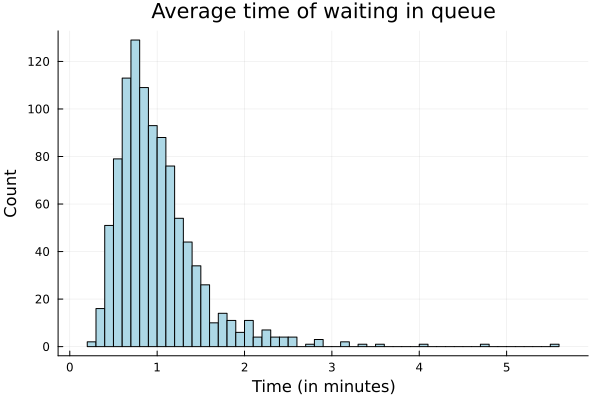

In [19]:
# Histogram średniego czasu oczekiwania

Plots.histogram(df1.śr_czas_ocz, ylabel="Count", xlabel="Time (in minutes)", title="Average time of waiting in queue", fillcolor="lightblue", label=false)

In [20]:
#Średni czas oczekiwania
mean(df1.śr_czas_ocz)

1.007034606243662

In [21]:
# Wykorzystanie stanowisk

mean(df1.czas_pracy_naj)/(60*10), mean(df1.czas_pracy_lep)/(60*10), mean(df1.czas_pracy_śr)/(60*10), mean(df1.czas_pracy_gor)/(60*10)

(0.8902783333333334, 0.8511783333333334, 0.780595, 0.0)